# Introduction:
The objective is to develop predictive models for Spasm in patients. The folloqing provides the results for analysis of spike rate in different regions of the brain vs. patients state divided into 3 category: rest, voluntary movement, spasm, obtained through analysis of the real time video recordings. The data set contains 185193 spikes. 

Data Dictionary:

* PatientID: Identification number assigned to each subject for privacy 
* ChannelName: The file name assigned to the recording channel
* NeuronID: An integer assigned to every neuron identified at each channel starting from 1 and increasing
* SpikeTime: The time of recording of the spike. (Marco can elaborate further on the time format)
* SpikeRate: Calculated as the inverse time between every spike and subsequent spike
* SpikeEventType: is a categorical variable indicating the state of the patient at the time of spike recording. The variable takes the following value:
    + ‘REST’: Indicates patient in resting or sleeping state (no observable movements)
    + 'SPASM_B': Indicates patient has visible spasm on BOTH sides
    + 'SPASM_L': Indicates patient has visible spasm on the LEFT sides
    + 'SPASM_R': Indicates patient has visible spasm on the RIGHT sides
    + 'Voluntary_B': Indicates patient has visible voluntary movement on BOTH sides
    + 'Voluntary_L': Indicates patient has visible voluntary movement on the LEFT sides
    + 'Voluntary_R’: Indicates patient has visible voluntary movement on the RIGHT sides


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Load Database
orig_df = pd.read_csv('redacted_spike_data.csv')
len(orig_df)

185193

In [3]:
# Inspect it
orig_df.head()

,Index,PatientID,ChannelName,NeuronID,SpikeTime,SpikeRate,EventTypeSide
0,0,1,microVIM_L_1,1,10.583409,0.000000,REST
1,1,1,microVIM_L_1,1,24.655727,0.071061,REST
2,2,1,microVIM_L_1,1,66.921773,0.023660,SPASM_B
3,3,1,microVIM_L_1,1,67.628909,1.414154,SPASM_B
4,4,1,microVIM_L_1,1,68.318864,1.449371,SPASM_B


In [4]:
df = orig_df.copy()
df.drop('Index', axis=1,inplace=True)

# Feature Extraction

### Get brain region, lateral and contact number

In [5]:
def getRegion(e):
    match = re.search(r'micro([a-zA-Z]+)_',e)
    if match:
        return match.group(1)
    else:
        return
def getLateral(e):
    match = re.search(r'micro([a-zA-Z]+)_([LR])_',e)
    if match:
        return match.group(2)
    else:
        return
def getCono(e):
    match = re.search(r'micro([a-zA-Z]+)_([LR])_(\d+)',e)
    if match:
        return match.group(3)
    else:
        return

df['Recording_Region'] = df['ChannelName'].map(getRegion)
df['Recording_Lateral'] = df['ChannelName'].map(getLateral)
df['Recording_ContactNo'] = df['ChannelName'].map(getCono)
df.drop('ChannelName', axis=1, inplace=True)

### Extract event type and lateral 

In [6]:
def getEvent(e):
    match = re.search(r'([a-zA-Z]+)_*',e)
    if match:
        return match.group(1)
    else:
        return
def getEventLateral(e):
    match = re.search(r'[a-zA-Z]+_*([LRB]*)',e)
    if match:
        return match.group(1)
    else:
        return
    
df['Event'] = df['EventTypeSide'].map(getEvent)
df['Event_Lateral'] = df['EventTypeSide'].map(getEventLateral)

df = df[(~df['Event'].isnull()) & ~(df['Event'] == 'None')]

In [7]:
df.head()

,PatientID,NeuronID,SpikeTime,SpikeRate,EventTypeSide,Recording_Region,Recording_Lateral,Recording_ContactNo,Event,Event_Lateral
0,1,1,10.583409,0.000000,REST,VIM,L,1,REST,
1,1,1,24.655727,0.071061,REST,VIM,L,1,REST,
2,1,1,66.921773,0.023660,SPASM_B,VIM,L,1,SPASM,B
3,1,1,67.628909,1.414154,SPASM_B,VIM,L,1,SPASM,B
4,1,1,68.318864,1.449371,SPASM_B,VIM,L,1,SPASM,B


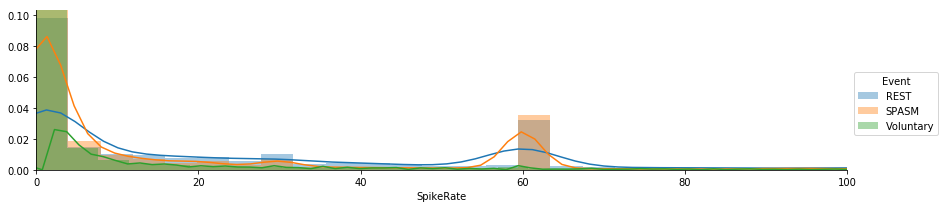

In [8]:
p = sns.FacetGrid(df, hue='Event', aspect=4)
p.map(sns.distplot, 'SpikeRate')
plt.xlim([0,100])
p.add_legend()


The spike rates distribution is very skewed. Also, we consider values over 80 as artifact due to the nature of the phenomenon.
First, values over 80 will be removed,

In [9]:
df = df[ (1 < df['SpikeRate'])]

In [10]:
df['logRate'] = np.log(df['SpikeRate'])

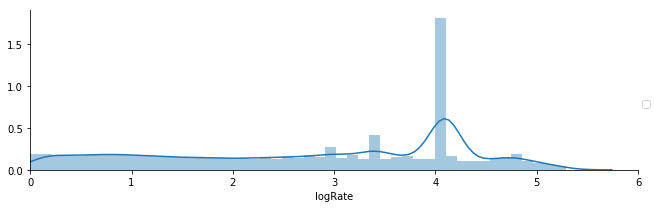

In [11]:
p = sns.FacetGrid(df, aspect=3)
p.map(sns.distplot, 'logRate')
plt.xlim([0,6])
p.add_legend()
plt.tight_layout()

Even logRate is still skewed. There might be noise in lower rates as well.

# Data Exploration 

Text(0.5,1,'Right Brain')

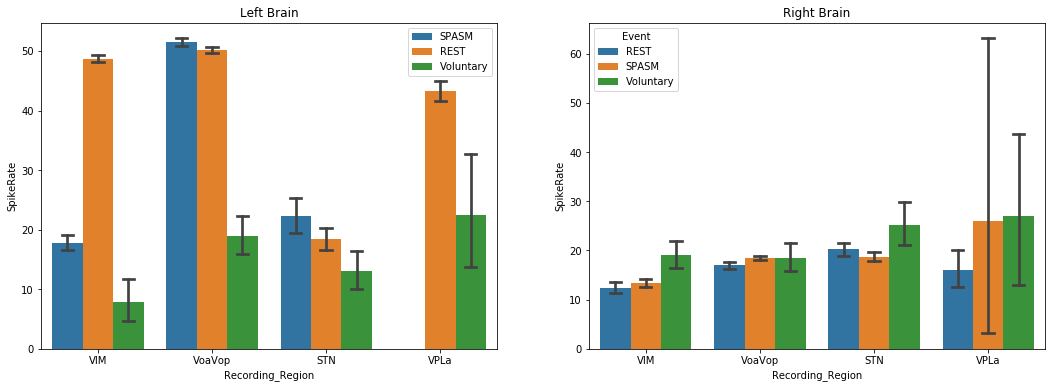

In [12]:
df_L = df[(df['Recording_Lateral']=='L') & (df['Event_Lateral'].isin(['R','','B']))]
df_R = df[(df['Recording_Lateral']=='R') & (df['Event_Lateral'].isin(['L','','B']))]



fig, (axis1,axis2) = plt.subplots(1,2,figsize=(18,6))

rateplot = sns.barplot(x='Recording_Region', y='SpikeRate', hue='Event',data=df_L, capsize=.1, ax=axis1)
axis1.set_title('Left Brain')
axis1.legend(loc='upper right')

rateplot = sns.barplot(x='Recording_Region', y='SpikeRate', hue='Event',data=df_R, capsize=.1, ax=axis2)
axis2.set_title('Right Brain')



Left brain seems to be more active during rest in VIM, VoaVop and VPLa. VoaVop is very active during muscle SPASM. (These two patients have injuries at left brain)

# Predictive models

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [14]:
map_region = {'STN':0, 'VIM':1, 'VPLa':2, 'VoaVop':3}
X_train = df_L[['Recording_Region', 'logRate']]
X_train.loc[:,'Recording_Region'] = X_train['Recording_Region'].map(map_region)

y_train = df_L['Event'].map({'REST':0, 'SPASM':1, 'Voluntary':2})


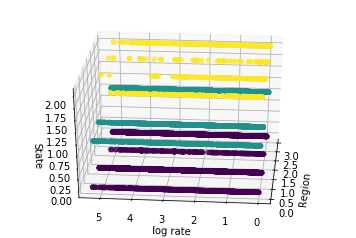

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['Recording_Region'], X_train['logRate'], y_train, c=y_train)
ax.set_xlabel('Region')
ax.set_ylabel('log rate')
ax.set_zlabel('State')
ax.view_init(30, 185)
plt.show()


In [18]:
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(GaussianNB())
classifiers.append(LinearSVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(RandomForestClassifier(random_state = random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":['Logistic Regression','SVMC', 'KNN', 
     'Gaussian', 'linear SVC', 'Decision Tree', 'Random Forest']})

In [19]:
cv_res

,Algorithm,CrossValMeans,CrossValerrors
0,Logistic Regression,0.695025,0.086504
1,SVMC,0.587468,0.190190
2,KNN,0.655968,0.137251
3,Gaussian,0.624109,0.209573
4,linear SVC,0.690725,0.074735
5,Decision Tree,0.594778,0.202726
6,Random Forest,0.594312,0.205178


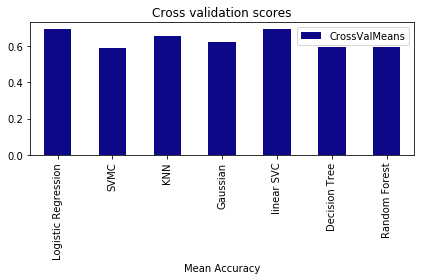

In [20]:
#g = sns.barplot(x='CrossValMeans',y='Algorithm',data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})

cv_res[['Algorithm', 'CrossValMeans']].plot.bar(x='Algorithm',y='CrossValMeans', colormap='plasma');
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")
plt.tight_layout()

In [27]:
map_region = {'STN':0, 'VIM':1, 'VPLa':2, 'VoaVop':3}
{'REST':0, 'SPASM':1, 'Voluntary':2}

{'REST': 0, 'SPASM': 1, 'Voluntary': 2}

It seems linear models are doing a good job predicting state of the patient. 

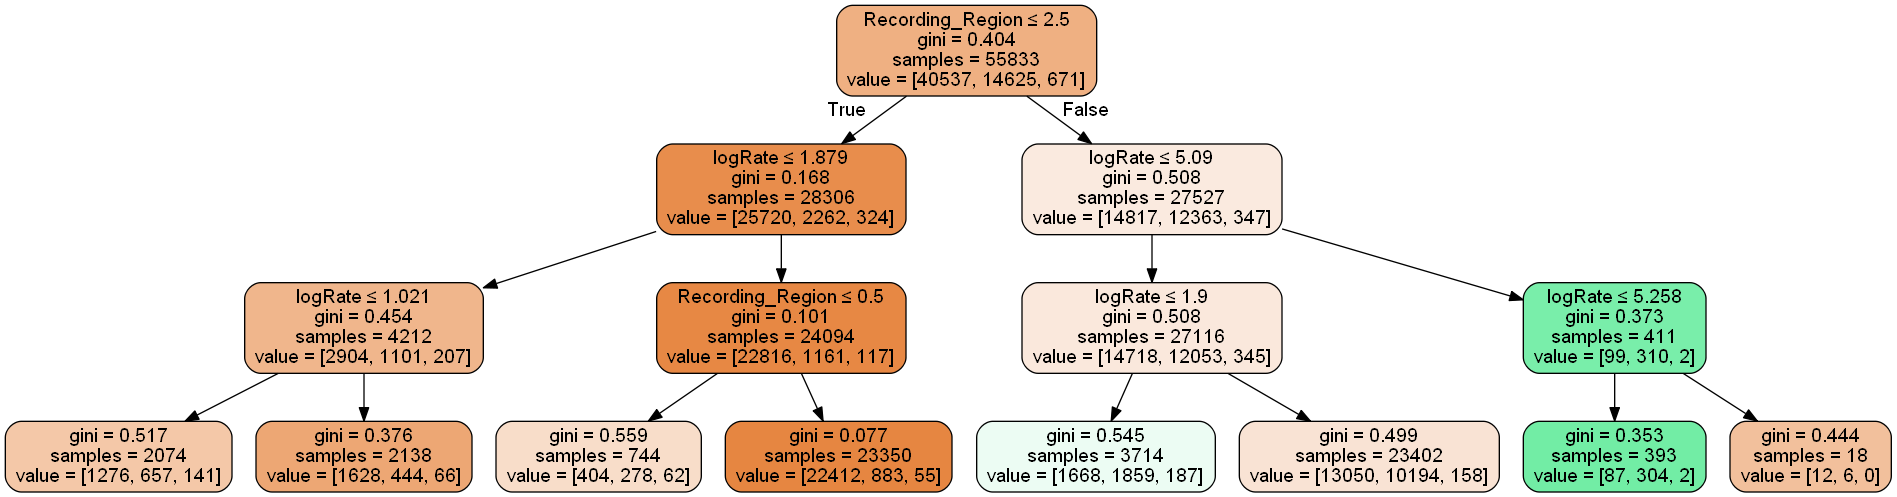

In [25]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

DT = DecisionTreeClassifier(max_depth=3)
DT.fit(X_train, y_train)
DT.feature_importances_
dot_data = StringIO()
export_graphviz(DT, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=list(X_train.columns))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())





In [28]:
DT.feature_importances_


array([0.87335338, 0.12664662])

In [29]:
list(X_train.columns)

['Recording_Region', 'logRate']